## Plot selected CellProfiler measurements for selected images

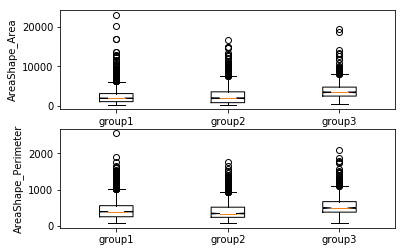

In [53]:
import matplotlib.pyplot as plt
import os
import pandas as pd

workdir = "/home/hajaalin/tmp"
filename = "imagingcourse_CP300_Cells.csv"
basename, extension = os.path.splitext(filename)

df = pd.read_csv(os.path.join(workdir, filename))

# These are the columns that will be kept
measurements = ['AreaShape_Area', 'AreaShape_Perimeter']
keep_cols = ['ImageNumber', 'Metadata_Plate']
keep_cols.extend(measurements)

drop_cols = [k for k in list(df.columns.values) if not k in keep_cols]
df.drop(drop_cols, axis=1, inplace=True)

# These are the image numbers we are interested in, grouped by visual inspection for example
image_groups = (('plate1', [1,2,3,5,8], 'group1'), \
                ('plate1', [13,21,34], 'group2'), \
                ('plate1', [55,89,144], 'group3'))

# add Group column
df['Group'] = 'None'
for ig in image_groups:
    #print(ig)
    df.loc[(df['Metadata_Plate'] == ig[0]) & (df.ImageNumber.isin(ig[1])), 'Group'] = ig[2]
df = df[(df.Group != 'None')]

df.head()

fig = plt.figure()
i=1
for m in measurements:
    ax = fig.add_subplot(len(measurements), 1, i, ylabel = m)
    g = []
    l = []
    for ig in image_groups: 
        g.append(df[df['Group']==ig[2]][m])
        l.append(ig[2])
    ax.boxplot(g, notch = True, labels=l);
    i = i+1

outputFilename = basename + "_selected_images" + extension
df.to_csv(os.path.join(workdir, outputFilename), index=False)


## Calculate per-image averages of the selected measurements and write to csv

In [54]:
# columns to group the results by
group_cols = ['Metadata_Plate', 'ImageNumber']

# exclude these from averaging
exclude_cols = ['ImageNumber', 'ObjectNumber', 'Metadata_']

# the list of measurements we want to average
measurements = [k for k in list(df.columns.values) if not k.startswith(tuple(exclude_cols))]

# https://stackoverflow.com/questions/35401691/groupby-and-calculate-mean-but-keeping-all-columns

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = df.groupby(group_cols)[measurements].mean()
# remove the metric_cols from df because we are going to replace them
# with the means in aggs
df.drop(measurements, axis=1, inplace=True)
# dedupe to leave only one row with each combination of group_cols
# in df
df.drop_duplicates(subset=group_cols, keep='last', inplace=True)
# add the mean columns from aggs into df
df = df.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

outputFilename = basename + "_selected_images_avg" + extension
df.to_csv(os.path.join(workdir, outputFilename), index=False)


